# Topic modeling (title)

In [16]:
# Importing libraries
import pandas as pd

# Load the cleaned data
title_data = pd.read_csv('../data/cleaned_wsb_title_withouttime.csv')

# Display data
print(title_data)

                                                   title   timestamp  \
0        it not about the money it about sending message  2021-01-28   
1      math professor scott steiner says the numbers ...  2021-01-28   
2                                        exit the system  2021-01-28   
3      new sec filing for gme can someone less retard...  2021-01-28   
4      not to distract from gme just thought our amc ...  2021-01-28   
...                                                  ...         ...   
53181      what learned investigating sava fud spreaders  2021-08-02   
53182  daily popular tickers thread for august 02 202...  2021-08-02   
53183       hitler reacts to the market being irrational  2021-08-02   
53184         daily discussion thread for august 02 2021  2021-08-02   
53185  fraternal association of gambling gentlemen an...  2021-08-02   

               tickers  
0                   []  
1                   []  
2                   []  
3       ['GME', 'FOR']  
4       ['

**Taking a look at the 20 most mentioned tickers**

In [17]:
# Flatten the tickers into a single list and count occurrences
ticker_counts = (
    title_data.explode('tickers')  # Explode the tickers list into individual rows
    .groupby('tickers')
    .size()
    .sort_values(ascending=False)  # Sort by count in descending order
    .head(21)  # Get the top 20 tickers
)

# Convert to DataFrame for better readability
top_tickers = ticker_counts.reset_index(name='count').rename(columns={'tickers': 'ticker'})

# Print the top 20 tickers
print(top_tickers)

            ticker  count
0               []  33918
1          ['GME']   5726
2          ['AMC']   1504
3            ['A']    659
4           ['DD']    615
5           ['BB']    561
6   ['GME', 'AMC']    462
7          ['RKT']    447
8           ['RH']    444
9          ['NOK']    392
10        ['UWMC']    265
11  ['AMC', 'GME']    227
12         ['YOU']    210
13        ['SPCE']    185
14           ['T']    118
15    ['GME', 'A']    117
16         ['ARE']    112
17          ['TD']    109
18          ['IT']    108
19           ['S']    108
20         ['FOR']     99


# BERTopics with lemmatization (using spaCy)

In [18]:
# https://maartengr.github.io/BERTopic/getting_started/quickstart/quickstart.html#installation
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Using spaCy for both lemmatization and stopword removal
def preprocess_with_spacy(docs):
    processed_docs = []
    # Process documents in batches for efficiency
    for doc in nlp.pipe(docs, batch_size=100, n_process=1):
        # Lemmatize and remove stopwords
        tokens = [token.lemma_ for token in doc 
                  if not token.is_stop and not token.is_punct and token.lemma_.isalpha()]
        processed_docs.append(' '.join(tokens))
    return processed_docs

# Extract raw documents (list of strings)
documents = title_data['title'].astype(str).tolist()

# Preprocess documents using spaCy function for lemmatization and stopword removal
processed_documents = preprocess_with_spacy(documents)

# Create a vectorizer model
vectorizer_model = CountVectorizer()

# Initialize BERTopic with the custom vectorizer
topic_model = BERTopic(vectorizer_model=vectorizer_model, verbose=True)

# Fit and transform the preprocessed documents to embeddings
topics, probs = topic_model.fit_transform(processed_documents)

# Get topic info
topic_info = topic_model.get_topic_info()


2024-12-18 00:14:30,157 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 1663/1663 [02:45<00:00, 10.04it/s]
2024-12-18 00:17:17,795 - BERTopic - Embedding - Completed ✓
2024-12-18 00:17:17,795 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-18 00:17:38,054 - BERTopic - Dimensionality - Completed ✓
2024-12-18 00:17:38,069 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-18 00:17:41,494 - BERTopic - Cluster - Completed ✓
2024-12-18 00:17:41,495 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-18 00:17:42,170 - BERTopic - Representation - Completed ✓


In [19]:
# Display topic info
print(topic_info.head())

# Topics to print
topics_to_print = [-1, 0, 1, 2, 3]

print("\n" + "\n".join([f"Topic {topic}: {topic_model.get_topic(topic)}" for topic in topics_to_print]))

   Topic  Count                               Name  \
0     -1  15422           -1_money_lose_month_time   
1      0    547  0_robinhood_cancel_restrict_block   
2      1    473   1_robinhood_search_remove_buying   
3      2    466             2_porn_loss_enjoy_jerk   
4      3    417     3_hedge_fund_hedgefund_manager   

                                      Representation  \
0  [money, lose, month, time, day, earning, milli...   
1  [robinhood, cancel, restrict, block, manipulat...   
2  [robinhood, search, remove, buying, block, rob...   
3  [porn, loss, enjoy, jerk, nsfw, fap, post, gue...   
4  [hedge, fund, hedgefund, manager, funder, turm...   

                                 Representative_Docs  
0  [want thank set pull money thing account thank...  
1  [cancel robinhood, robinhood cancel order shar...  
2  [robinhood gme amc, search robinhood not allow...  
3                  [loss porn, loss porn, loss porn]  
4               [hedge fund, hedge fund, hedge fund]  

Topic -

**Data for Performance Evaluation**

In [20]:
# Ensure lengths match
if len(topics) != len(title_data):
    raise ValueError(f"Length mismatch: topics({len(topics)}) and title_data({len(title_data)})")

# Add the topic column
title_data['topic'] = topics

# Retrieve topic names with a fallback for missing topics
topic_names = {}
for topic in set(topics):
    words = topic_model.get_topic(topic)
    if words:  # If topic has words
        topic_names[topic] = f"Topic {topic}: {', '.join([word for word, _ in words])}"
    else:
        topic_names[topic] = f"Topic {topic}: No Keywords"

# Map topic numbers to their names
title_data['topic_name'] = title_data['topic'].map(topic_names)

# Save the updated DataFrame
title_data[['title', 'topic', 'topic_name']].to_csv('results/labeled_title_topics_with_lemma.csv', index=False)

# BERTopic without lemmatization

In [21]:
# https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html#removing-stop-words
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# Extract documents (list of strings)
documents = title_data['title'].astype(str).tolist()

# Create a vectorizer model that removes English stopwords
vectorizer_model = CountVectorizer(stop_words='english')

# Initialize BERTopic with the custom vectorizer
topic_model = BERTopic(vectorizer_model=vectorizer_model, verbose=True)

# Fit and transform the preprocessed documents to embeddings
topics, probs = topic_model.fit_transform(documents)

# Get topic info
topic_info = topic_model.get_topic_info()

2024-12-18 00:17:43,496 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 1663/1663 [01:38<00:00, 16.97it/s]
2024-12-18 00:19:23,527 - BERTopic - Embedding - Completed ✓
2024-12-18 00:19:23,543 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-18 00:19:36,773 - BERTopic - Dimensionality - Completed ✓
2024-12-18 00:19:36,773 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-18 00:19:38,583 - BERTopic - Cluster - Completed ✓
2024-12-18 00:19:38,602 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-18 00:19:39,578 - BERTopic - Representation - Completed ✓


In [22]:
# Display topic info
print(topic_info.head())

# Topics to print
topics_to_print = [-1, 0, 1, 2, 3]

print("\n" + "\n".join([f"Topic {topic}: {topic_model.get_topic(topic)}" for topic in topics_to_print]))

   Topic  Count                            Name  \
0     -1  17842   -1_gme_stock_stocks_robinhood   
1      0    683          0_dip_dips_buy_dipping   
2      1    483       1_shares_share_bought_200   
3      2    457        2_apes_ape_strong_fellow   
4      3    419  3_gamestop_games_officer_chief   

                                      Representation  \
0  [gme, stock, stocks, robinhood, holding, money...   
1  [dip, dips, buy, dipping, bought, buying, dipp...   
2  [shares, share, bought, 200, 100, smallest, sh...   
3  [apes, ape, strong, fellow, monkeys, stronk, m...   
4  [gamestop, games, officer, chief, mania, appoi...   

                                 Representative_Docs  
0  [i holding gme don lose hope people remember w...  
1           [buy that dip, buy the dip, buy the dip]  
2  [these are my shares and no one else can have ...  
3  [we are at it again apes, which one of you ape...  
4                [gamestop, next gamestop, gamestop]  

Topic -1: [('gme', 0.0014

**Data for Performance Evaluation**

In [23]:
# Ensure lengths match
if len(topics) != len(title_data):
    raise ValueError(f"Length mismatch: topics({len(topics)}) and title_data({len(title_data)})")

# Add the topic column
title_data['topic'] = topics

# Retrieve topic names with a fallback for missing topics
topic_names = {}
for topic in set(topics):
    words = topic_model.get_topic(topic)
    if words:  # If topic has words
        topic_names[topic] = f"Topic {topic}: {', '.join([word for word, _ in words])}"
    else:
        topic_names[topic] = f"Topic {topic}: No Keywords"

# Map topic numbers to their names
title_data['topic_name'] = title_data['topic'].map(topic_names)

# Save the updated DataFrame
title_data[['title', 'topic', 'topic_name']].to_csv('results/labeled_title_topics_without_lemma.csv', index=False)

# Tool to extract given topic input in percentage over time

         date  total_posts  topic_posts  percentage
1  2021-01-29        15694       2102.0   13.393654
0  2021-01-28         1197        272.0   22.723475
2  2021-01-30         1424         97.0    6.811798
8  2021-02-05         2598         95.0    3.656659
9  2021-02-06         2791         92.0    3.296310
3  2021-01-31          939         72.0    7.667732
7  2021-02-04         1671         50.0    2.992220
6  2021-02-03         2643         44.0    1.664775
5  2021-02-02         1502         43.0    2.862850
4  2021-02-01          884         37.0    4.185520


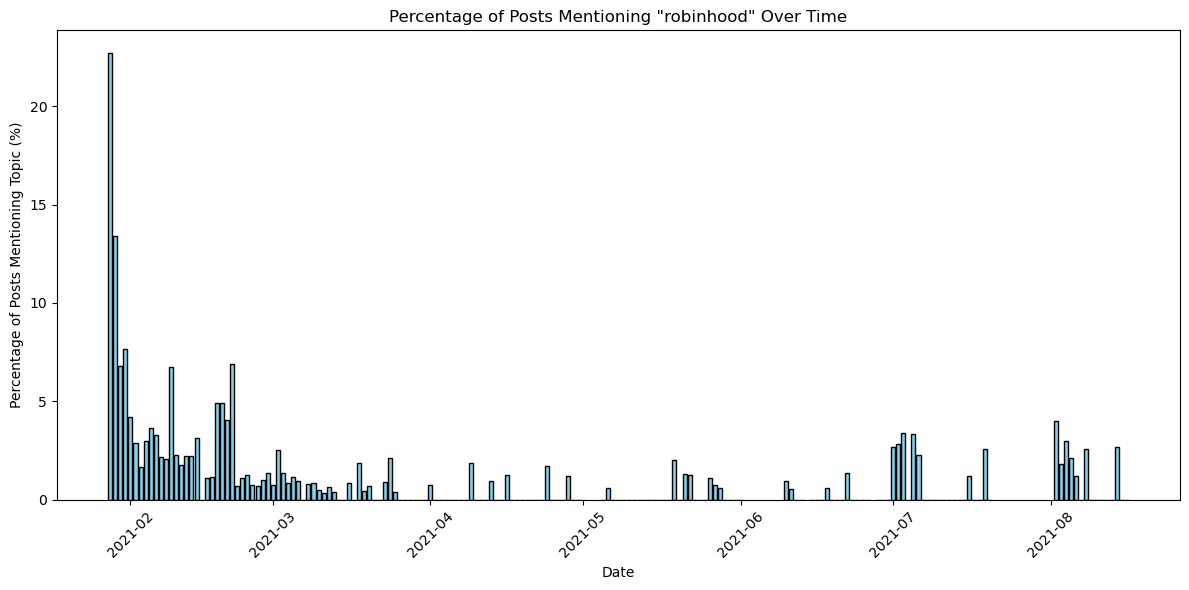

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure timestamp is datetime
title_data['timestamp'] = pd.to_datetime(title_data['timestamp'])

# Define topic
topic = "robinhood"

# Create a boolean column indicating if the topic is mentioned in a post
title_data['mentions_topic'] = title_data['title'].str.contains(rf'\b{topic}\b', case=False, na=False)

# Extract date
title_data['date'] = title_data['timestamp'].dt.date

# Count how many posts per day (total)
daily_total = title_data.groupby('date').size().reset_index(name='total_posts')

# Count how many posts mention the topic per day
daily_topic = title_data[title_data['mentions_topic']].groupby('date').size().reset_index(name='topic_posts')

# Merge the two DataFrames on 'date'
merged = pd.merge(daily_total, daily_topic, on='date', how='left')

# Fill NaN in topic_posts with 0 (days with no mentions)
merged['topic_posts'] = merged['topic_posts'].fillna(0)

# Compute percentage
merged['percentage'] = (merged['topic_posts'] / merged['total_posts']) * 100

# Sort by highest number of topic_posts
merged = merged.sort_values(by='topic_posts', ascending=False)

# Print the sorted table
print(merged.head(10))

# Plot the percentage over time as a bar chart
plt.figure(figsize=(12,6))
plt.bar(merged['date'], merged['percentage'], color='skyblue', edgecolor='black')
plt.title(f'Percentage of Posts Mentioning "{topic}" Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage of Posts Mentioning Topic (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
